In [1]:
import tensorflow as tf

import tensorflow_datasets as tfds 



/home/ait_guest/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from tensorflow_examples.models.pix2pix import pix2pix

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [3]:
dataset, info = tfds.load("oxford_iiit_pet:3.*.*", with_info=True)

2022-04-12 11:47:34.351458: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 11:47:34.358481: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 11:47:34.358736: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 11:47:34.360015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 11:47:34.360251: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from S

In [5]:
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    input_mask-=1
    return input_image, input_mask

In [4]:
def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"],(128,128))
    input_mask = tf.image.resize(datapoint["segmentation_mask"],(128,128))

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask

In [6]:
TRAIN_LENGTH = info.splits["train"].num_examples
BATCH_SIZE = 8
BUFFER_SIZE = 500
STEPS_PER_EPOCH = TRAIN_LENGTH

In [7]:
train_images = dataset["train"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset["test"].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
        super().__init__()
        self.augmented_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augmented_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    
    def call(self, inputs, labels):
        inputs = self.augmented_inputs(inputs)
        labels = self.augmented_labels(labels)
        return inputs, labels

In [9]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_batches = test_images.batch(BATCH_SIZE)

In [10]:
def display(display_list):
    plt.figure(figsize=(15,15))

    title=["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()

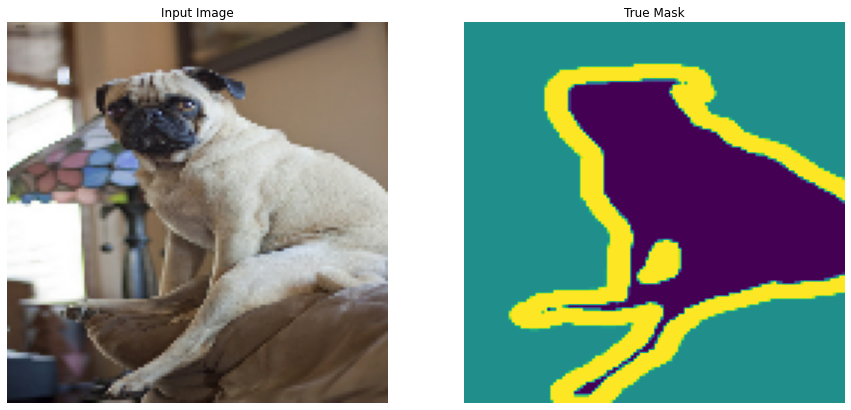

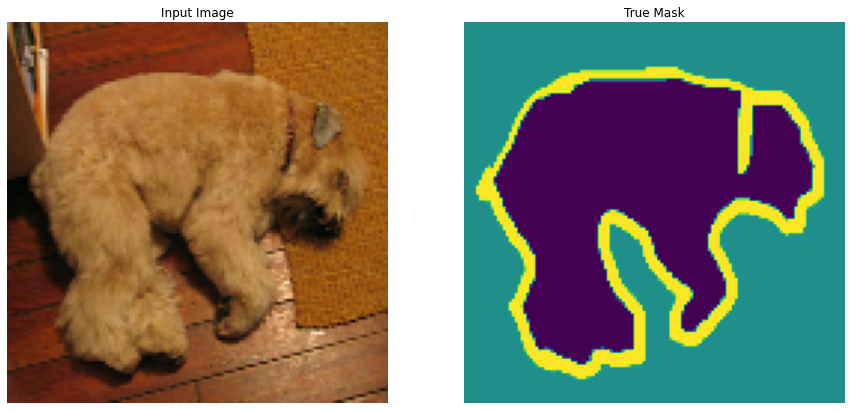

In [19]:
for images, mask in train_batches.take(2):
    sample_image, sample_mask = images[0], mask[0]
    display([sample_image,sample_mask])

Define Model

In [11]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128,128,3],include_top=False)

layer_names = [
    "block_1_expand_relu",
    "block_3_expand_relu",
    "block_6_expand_relu",
    "block_13_expand_relu",
    "block_16_project"
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

In [12]:
up_stack = [
    pix2pix.upsample(256,3),
    pix2pix.upsample(128,3),
    pix2pix.upsample(64,3),
    pix2pix.upsample(32,3),
]

In [13]:
def unet_model(output_channels:int):
    inputs = tf.keras.layers.Input(shape=[128,128,3])

    skips = down_stack(inputs)
    x = skips[-1]
    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack,skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x,skip])
    
    last = tf.keras.layers.Conv2DTranspose(
        filters=output_channels, kernel_size=3, strides=2,
        padding="same"
    )

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

Train Model

In [14]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer="adam", 
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

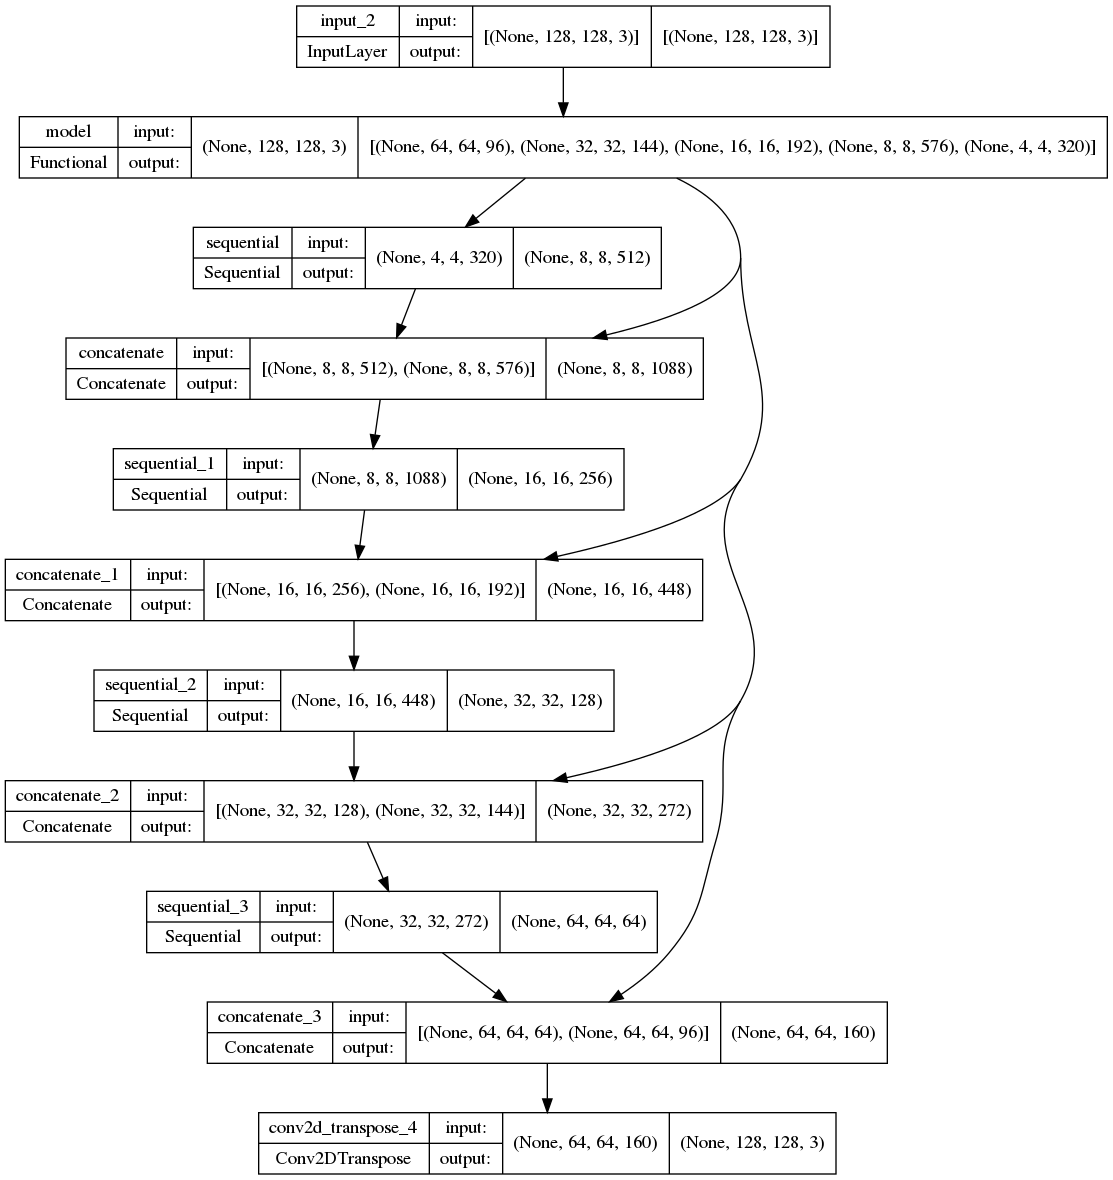

In [16]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [15]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[...,tf.newaxis]
    return pred_mask[0]

In [16]:
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image)
            display([image[0],mask[0],create_mask(pred_mask)])
    else:
        display([sample_image,sample_mask,create_mask(model.predict(sample_image[tf.newaxis, ...]))])

2022-04-12 11:09:26.970401: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100
2022-04-12 11:09:32.837680: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.15GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


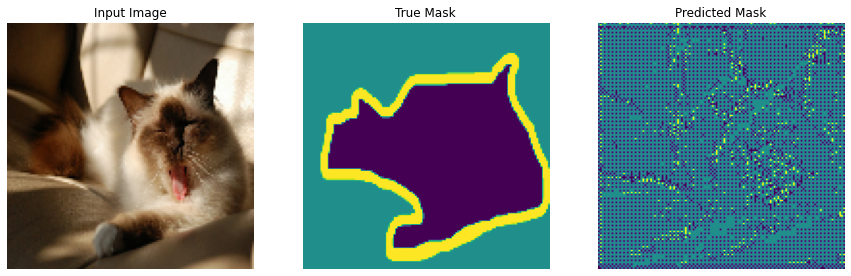

In [19]:
show_predictions()

In [17]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print("\nSample prediction after epochs {}\n".format(epoch+1))

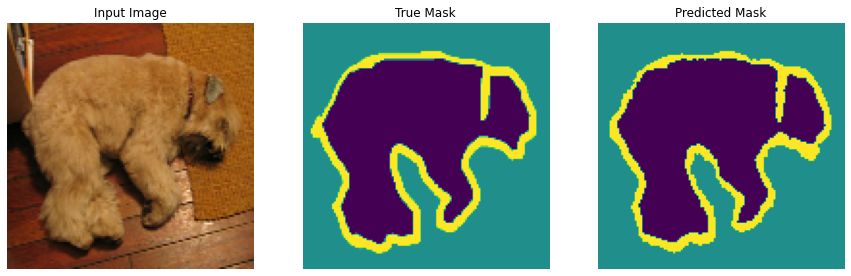


Sample prediction after epochs 20

3680/3680 [==============================] - 124s 34ms/step - loss: 0.0743 - accuracy: 0.9621


In [20]:
EPOCHS = 20
VAL_SUBSPILTS = 5
VALIDATION_STEPS = info.splits["test"].num_examples

model_history = model.fit(train_batches, 
                        epochs=EPOCHS,
                        steps_per_epoch=STEPS_PER_EPOCH,
                        validation_steps=VALIDATION_STEPS,
                        validation_data=test_batches,
                        callbacks=[DisplayCallback()]
)

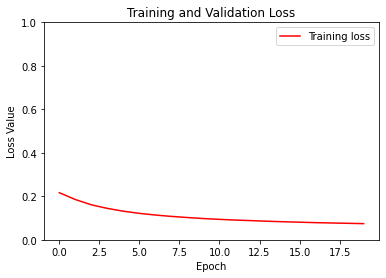

In [24]:
loss = model_history.history["loss"]
#val_loss = model_history.history["val_loss"]

plt.figure()
plt.plot(model_history.epoch, loss, "r", label="Training loss")
#plt.plot(model_history.epoch,val_loss, "bo", label="Validation loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.ylim([0,1])
plt.legend()
plt.show()